In [34]:

"""All TODO"""
# TODO: Add ground-truth data stations as different shape / colour nodes
# TODO: Plot all timeseries data in full, knock out two unacceptable ones and then plot omitting suspect and unchecked data
# TODO: interpolate missing data (with quick missingness checks - check DEVUL assignment feedback on this)
# TODO: GNN iteration 1 inc. shallow aquifer then test metrics to decide on inclusion (RMSE, MSE etc). See Notion: Project Data > Preprocessing Steps > 0b. > Full Notes (Page)

'All TODO'

Imports

In [2]:
import os
import ast
import folium
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyproj import Transformer
from shapely.geometry import box
from datetime import datetime, timedelta

Mesh building function definition

In [3]:
def build_mesh(shape_filepath, grid_resolution=1000):
    """
    Builds a spatial mesh of nodes (centroids of grid cells) within the input catchment boundary.

    Args:
        shape_filepath (str): Path to the catchment boundary shapefile.
        grid_resolution (int): Resolution of the grid (default 1 km resolution, EPSG:27700 is in meters).

    Returns:
        tuple: (mesh_nodes_table_df, mesh_nodes_gdf)
            - mesh_nodes_table_df (pd.DataFrame): Node ID and coordinates.
            - mesh_nodes_gdf (gpd.GeoDataFrame): Node ID, coordinates, and geometry (Point).
    """
    # Load spatial boundary shape file
    catchment_polygon = gpd.read_file(shape_filepath)
    catchment_polygon = catchment_polygon.to_crs(epsg=27700) # Convert to British National Grid

    # Check polygon geometry -> if shapefile has multiple features then dissolve them
    if len(catchment_polygon) > 1:
        print("\nMultiple polygons found in the catchment boundary. Merging into a single geometry.")
        catchment_geometry = catchment_polygon.unary_union
    else:
        print("\nSingle polygon found in the catchment boundary.")
        catchment_geometry = catchment_polygon.geometry.iloc[0]

    # Get the bounds of the catchment and set grid resolution (in km)
    minx, miny, maxx, maxy = catchment_polygon.total_bounds
    print(f"Catchment bounding box: min_x={minx}, min_y={miny}, max_x={maxx}, max_y={maxy}")
    
    ## ---- Set up coordinate node mesh ----

    # Generate bottom left coordinates of grid cells
    x_coordinates_bottomleft = np.arange(minx, maxx + grid_resolution, grid_resolution)
    y_coordinates_bottomleft = np.arange(miny, maxy + grid_resolution, grid_resolution)

    print(f"\nNumber of x-coordinates (bottom-left): {len(x_coordinates_bottomleft)}")
    print(f"Number of y-coordinates (bottom-left): {len(y_coordinates_bottomleft)}")

    # Initialise grid cell list and set up regular grid of points within the bounding box
    grid_cells = []
    for x in x_coordinates_bottomleft:
        for y in y_coordinates_bottomleft:
            cell = box(x, y, x + grid_resolution, y + grid_resolution)
            grid_cells.append(cell)

    print(f"\nGenerated {len(grid_cells)} grid cells within bounding box (before filtering).")

    grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:27700")

    # Keep only grid cells that intersect the catchment
    grid_intersected = gpd.overlay(grid_gdf, gpd.GeoDataFrame(geometry=[catchment_geometry], crs="EPSG:27700"), how='intersection', keep_geom_type=True)
    mesh_nodes_gdf = grid_intersected.copy() # Make copy to avoid SettingWithCopyWarning
    print(f"Filtered down to catchment boundary containing {len(grid_intersected)} nodes")

    ## ---- Convert to table ----

    # Calculate the centroid of each (potentially clipped) grid cell
    mesh_nodes_gdf['geometry'] = mesh_nodes_gdf.geometry.representative_point() # previously as .centroid

    # Add original Easting/Northing coordinates (as in EPSG:27700)
    mesh_nodes_gdf['easting'] = mesh_nodes_gdf.geometry.x
    mesh_nodes_gdf['northing'] = mesh_nodes_gdf.geometry.y
    mesh_nodes_gdf['node_id'] = range(len(mesh_nodes_gdf)) # UNID

    # Convert to WGS84 (EPSG:4326) to add lat/lon for visualisations
    mesh_nodes_4326 = mesh_nodes_gdf.to_crs(epsg=4326)
    mesh_nodes_gdf['lon'] = mesh_nodes_4326.geometry.x
    mesh_nodes_gdf['lat'] = mesh_nodes_4326.geometry.y

    # Select the columns needed for node table
    mesh_nodes_table = mesh_nodes_gdf[['node_id', 'easting', 'northing', 'lon', 'lat']]
    
    # Save the mesh nodes table and gdf to appropriate files
    mesh_nodes_table.to_csv("data/eden_catchment_mesh_nodes.csv", index=False)
    mesh_nodes_gdf.to_file("data/eden_catchment_mesh_nodes.gpkg", layer='mesh_nodes', driver='GPKG')  # GeoPackage
    # mesh_nodes_gdf.to_file("data/eden_catchment_mesh_nodes.shp", driver='ESRI Shapefile')  # Uncomment to save as Shapefile

    print("\nFirst few mesh nodes (centroids with coordinates):")
    print(mesh_nodes_table.head())
    print(f"\nTotal number of mesh nodes (centroids) for the catchment: {len(mesh_nodes_table)}\n")
    
    return mesh_nodes_table, mesh_nodes_gdf, catchment_polygon

Create mesh using input shape file

In [4]:
# Define spatial boundary shape - file from https://nrfa.ceh.ac.uk/data/station/spatial_download/76007
shape_filepath = "data/eden_catchment_boundary/NRFA_catchments.shp"
mesh_nodes_table, mesh_nodes_gdf, catchment_polygon = build_mesh(shape_filepath, grid_resolution=1000)


Single polygon found in the catchment boundary.
Catchment bounding box: min_x=326025.0, min_y=495525.0, max_x=388875.0, max_y=581725.0

Number of x-coordinates (bottom-left): 64
Number of y-coordinates (bottom-left): 88

Generated 5632 grid cells within bounding box (before filtering).
Filtered down to catchment boundary containing 2477 nodes

First few mesh nodes (centroids with coordinates):
   node_id   easting  northing       lon        lat
0        0  326800.0  528012.5 -3.135741  54.641893
1        1  326525.0  528925.0 -3.140231  54.650051
2        2  326650.0  529687.5 -3.138486  54.656920
3        3  327000.0  539475.0 -3.135516  54.744910
4        4  326925.0  539712.5 -3.136740  54.747033

Total number of mesh nodes (centroids) for the catchment: 2477



Folium interactive map (open from html file for full view). Catchment boundary currently interactive.

In [5]:
def plot_interactive_mesh(mesh_nodes_gdf, catchment_polygon, interactive=True):
    """
    Build an interactive folium map of the mesh with map tile and node/boundary toggles.

    Args:
        mesh_nodes_gdf (gpd.GeoDataFrame): Node ID, coordinates, and geometry (Point).
        catchment_polygon (gpd.GeoJson): Catchment area polygon.
    """
    map_blue = '#354c7c'
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    esri = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}"
    esri_attr = "Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ"
    
    # Static map when select, interactive otherwise
    if not interactive:
        fig, ax = plt.subplots(figsize=(10, 10))
        mesh_nodes_gdf.plot(ax=ax, color=map_blue, markersize=1.5)
        catchment_polygon.plot(ax=ax, facecolor='none', edgecolor=map_blue, linewidth=1)

        plt.xlabel("EPSG:27700 Easting (m)")
        plt.ylabel("EPSG:27700 Northing (m)")
        plt.title("Mesh Centroids for Eden Catchment (Resolution: 1km x 1km)")
        
        plt.savefig(f"figures/eden_catchment/mesh_map/{timestamp}_static_mesh.png", dpi=300)
        plt.show()
        
    else:
        # Create base map centered on centre of mesh
        map_center = [mesh_nodes_gdf['lat'].mean(), mesh_nodes_gdf['lon'].mean()]

        # Define map tile layers
        map = folium.Map(location=map_center, zoom_start=10, tiles=None)

        # Add tile layers (esri visible by default, others in toggle)
        folium.TileLayer(tiles=esri, attr=esri_attr, name='Topo', show=True).add_to(map)
        folium.TileLayer('CartoDB positron', name='Light', show=False).add_to(map)
        folium.TileLayer('CartoDB dark_matter', name='Dark', show=False).add_to(map)

        # Add all node centroids as circle markers
        mesh_layer = folium.FeatureGroup(name="Mesh Nodes")
        for col, row in mesh_nodes_gdf.iterrows():
            folium.CircleMarker(location=[row['lat'], row['lon']], radius=1, color=map_blue,
                                fill=True, fill_opacity=0.6).add_to(mesh_layer)
            
        # TODO: Add ground-truth data stations as different shape / colour nodes

        # Add solid catchment boundary polygon to the map
        folium.GeoJson(catchment_polygon, name='Catchment Boundary', 
                    style_function=lambda x: {'color': map_blue, 'weight': 2, 'fillColor': map_blue,
                                                'fillOpacity': 0.15}).add_to(map)

        # Add layer control to toggle catchment boundary, mesh and map tiles
        mesh_layer.add_to(map)
        folium.LayerControl().add_to(map)

        # Save to html (unique by timestamp) and display in notebook
        map.save(f"figures/eden_catchment/mesh_map/{timestamp}_mesh.html")
        return map


In [6]:
# Show map (select interactive vs static)
interactive = True
plot_interactive_mesh(mesh_nodes_gdf, catchment_polygon, interactive)

Basic matplotlib map

Import Station Data using DEFRA API

In [7]:
# Convert alphanumeric OS grid ref to easting, northing, lat, lon
def grid_ref_to_coords(grid_ref):
    """
    Convert OS Grid references into espg 27700 easting and northing values, then into
    espg 4326 coordinate ref system (longitude and latitude) for future visualisaations.
    """
    # Transformer to WGS84 (for lat/long coordinate transformations)
    transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
    
    # Clean grid references
    grid_ref = grid_ref.strip().upper()
    
    # Split to letter and numeric
    letter_only = grid_ref[:2]  # e.g. "NY" (from NY123456)
    numeric_only = grid_ref[2:]  # e.g. "123456" (from NY123456)
    
    # Check expected form (paired values)
    if len(numeric_only) % 2 != 0:
        raise ValueError(f"Invalid grid reference: {grid_ref}")
    
    easting_base, northing_base = grid_letters[letter_only]  # e.g. "300000, 500000" from NY (check ref file)
    half = len(numeric_only) // 2  # Seperate easting and northing (e.g. "123", "456")
    easting_offset = int(numeric_only[:half].ljust(5, '0'))  # e.g. "123" -> 12300 m
    northing_offset = int(numeric_only[half:].ljust(5, '0'))  # e.g. "456" -> 45600 m
    
    easting = int(easting_base + easting_offset)  # e.g. 300000 + 12300 = 312300 m
    northing = int(northing_base + northing_offset)  # e.g. 500000 + 45600 = 545600 m
    lon, lat = transformer.transform(easting, northing)  # Transform 312300, 545600 to lat, long (epsg:4326)
    
    return pd.Series([easting, northing, lat, lon])

# Use lookup file to create a dict of zipped grid letter and value lookup objects
grid_lookup_df = pd.read_csv("data/os_grid_squares.csv")
grid_letters = dict(zip(grid_lookup_df['grid_letters'], zip(grid_lookup_df['easting_base'], grid_lookup_df['northing_base'])))

# Apply to the station CSV
stations_df = pd.read_csv("data/station_list.csv")
stations_df[['easting', 'northing', 'lat', 'lon']] = stations_df['grid_ref'].apply(grid_ref_to_coords)

# Save as csv and check head and length
stations_df.to_csv("data/station_list_with_coords.csv", index=False)
print(f"Station location reference table:\n\n{stations_df.head()}")
print(f"\nTotal Stations: {len(stations_df)}")

Station location reference table:

  station_id    grid_ref   easting  northing        lat       lon
0     NY36_2  NY39146790  339140.0  567900.0  55.001931 -2.952971
1     NY46_3  NY46526426  346520.0  564260.0  54.970074 -2.836931
2    NY55_71  NY53825337  353820.0  553370.0  54.872953 -2.721158
3    NY54_54  NY56354839  356350.0  548390.0  54.828432 -2.680981
4    NY54_56  NY51774289  351770.0  542890.0  54.778590 -2.751349

Total Stations: 15


**API Documentation notes:**

1. The API calls that return readings data have a soft limit of 100,000 rows per-call which can be overridden by setting a _limit parameter. There is a hard limit of 2,000,000 rows, which cannot be overridden.
2. The primary identifier for most stations uses a GUID style identifier called an SUID. These are used in the URL for the station and given as the value of the notation property in the station metadata.  
    a. Wiski identifier (wiskiID) is also available for my subset of stations and data type  
3. All monitoring stations can be filtered by name, location and other parameters. See https://environment.data.gov.uk/hydrology/doc/reference#stations-summary for full metadata details

In [8]:
# Get metadata - NB: Wiski is the water information system used by DEFRA (see doc notes)
def get_station_metadata(wiski_id):
    
    params = {'wiskiID': wiski_id}
    response = requests.get(base_url, params=params)
    
    # If response is good (200) return metadata items as single metadata column
    if response.status_code == 200:
        data = response.json()
        if data['items']:
            return data['items'][0]  # Only one list index per station
    return None

# Retrieving full metadata for all EA hydrological monitoring stations from the DEFRA Hyprology Explorer API
base_url = "https://environment.data.gov.uk/hydrology/id/stations" 
stations_df['metadata'] = stations_df['station_id'].apply(get_station_metadata)

# Convert metadata from string to dict using ast
stations_df['metadata'] = stations_df['metadata'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
stations_df.head()


,station_id,grid_ref,easting,northing,lat,lon,metadata
0,NY36_2,NY39146790,339140.0,567900.0,55.001931,-2.952971,{'@id': 'http://environment.data.gov.uk/hydrol...
1,NY46_3,NY46526426,346520.0,564260.0,54.970074,-2.836931,{'@id': 'http://environment.data.gov.uk/hydrol...
2,NY55_71,NY53825337,353820.0,553370.0,54.872953,-2.721158,{'@id': 'http://environment.data.gov.uk/hydrol...
3,NY54_54,NY56354839,356350.0,548390.0,54.828432,-2.680981,{'@id': 'http://environment.data.gov.uk/hydrol...
4,NY54_56,NY51774289,351770.0,542890.0,54.778590,-2.751349,{'@id': 'http://environment.data.gov.uk/hydrol...


In [9]:
def get_station_measures(row):
    """See https://environment.data.gov.uk/hydrology/doc/reference#measures-summary for measures data"""
    # Exract ID and metadata
    metadata = row.get('metadata')
    station_id = row.get('station_id')

    # Continue if the required things exist in the correct form
    if isinstance(metadata, dict) and '@id' in metadata:
        
        # Request the measures data
        response = requests.get(f"{metadata['@id']}/measures", timeout=10)
        
        if response.status_code == 200:
            # If response code okay then return json response (items key) converted to dict
            return response.json().get('items', [])
        
        else:
            print(f"API request failed for station {station_id}: {response.status_code}")
    else:
        print(f"Warning: Station {station_id} has no associated @id metadata")
    return []

# Apply function across rows and display head to check
stations_df['measures'] = stations_df.apply(get_station_measures, axis=1)

# Convert measures from string to dict using ast and extract some initial useful info as flattened columns
stations_df['metadata'] = stations_df['metadata'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
stations_df['station_name'] = stations_df['metadata'].apply(lambda x: x.get('label') if isinstance(x, dict) else None)
stations_df['measure_uri'] = stations_df['measures'].apply(lambda x: x[0]['@id'] if x else None)

# Save as csv and check head
stations_df.to_csv("data/station_list_with_metadata_measures.csv", index=False)
stations_df.head()

,station_id,grid_ref,easting,northing,lat,lon,metadata,measures,station_name,measure_uri
0,NY36_2,NY39146790,339140.0,567900.0,55.001931,-2.952971,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,LONGTOWN,http://environment.data.gov.uk/hydrology/id/me...
1,NY46_3,NY46526426,346520.0,564260.0,54.970074,-2.836931,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Scaleby,http://environment.data.gov.uk/hydrology/id/me...
2,NY55_71,NY53825337,353820.0,553370.0,54.872953,-2.721158,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Castle carrock,http://environment.data.gov.uk/hydrology/id/me...
3,NY54_54,NY56354839,356350.0,548390.0,54.828432,-2.680981,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Croglin,http://environment.data.gov.uk/hydrology/id/me...
4,NY54_56,NY51774289,351770.0,542890.0,54.778590,-2.751349,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Baronwood,http://environment.data.gov.uk/hydrology/id/me...


In [10]:

def download_readings(measure_uri, startdate_str, enddate_str, max_per_request=50000):
    """
    Download hydrological readings for each station from DEFRA Hydrology API within given dates.
    Max requests set at 50000 with pagination used when readings exceeed this.
    """
    all_measure_readings = []
    offset = 0
    
    while True:
        if not isinstance(measure_uri, str) or not measure_uri.startswith("http"):
            print(f"Invalid URI: {measure_uri}")
            return []

        params = {
            '_limit': max_per_request,
            '_offset': offset,  # offset for when number of readings exceeds max_per_request (pagination)
            'min-dateTime': startdate_str,
            'max-dateTime': enddate_str
        }
        
        # Call API with defined parameters
        response = requests.get(f"{measure_uri}/readings", params=params)
        
        if response.status_code == 200:
            readings = response.json().get('items', [])
            
            # If readings are found append them to all_measure_readings list
            if readings:
                df = pd.DataFrame(readings)
                all_measure_readings.append(df)

                # Check if the max_readings_per_request was received (indicating more data might exist)
                if len(readings) < max_per_request:
                    break  # No more readings
                else:
                    offset += max_per_request # Move offset for next chunk to retrieve
            else:
                print(f"    No data in: {measure_uri}\n    Length: 0")
                break
        else:
            print(f"Failed for {measure_uri} - response code: {response.status_code}")
            return pd.DataFrame()

    if all_measure_readings:
        final_df = pd.concat(all_measure_readings, ignore_index=True)
        print(f"    Done: {measure_uri}\n    Length: {len(final_df)}")
        return final_df
    else:
        print(f"    No data in: {measure_uri}")
        return pd.DataFrame()
    
# Download station data for stations in catchment
start = '2014-01-01T00:00:00'
end = '2025-01-01T00:00:00'

print(f"Collecting data from {start[:-9]} to {end[:-9]}...")

count = 1

for index, row in stations_df.iterrows():
    # Pull station data
    uri = row['measure_uri']
    print(f"\n({count}/{len(stations_df)}) Processing measure: {uri+'/readings'}")
    df_readings = download_readings(uri, start, end)
    
    # Assign names to timeseries data using stations_df
    df_readings['station_name'] = row['station_name'].title().strip()
    
    # Save returned dataframe
    measure_id = uri.split("/")[-1]
    df_readings.to_csv(f"data/gwl/{measure_id}_readings.csv")
    count += 1
        


(1/15) Processing measure: http://environment.data.gov.uk/hydrology/id/measures/6257f7cc-f392-4a98-814a-1d8f20e3fadd-gw-logged-i-subdaily-mAOD-qualified/readings
    Done: http://environment.data.gov.uk/hydrology/id/measures/6257f7cc-f392-4a98-814a-1d8f20e3fadd-gw-logged-i-subdaily-mAOD-qualified
    Length: 95679

(2/15) Processing measure: http://environment.data.gov.uk/hydrology/id/measures/dbdc1aca-14eb-45e8-beb5-204d5e5f9133-gw-logged-i-subdaily-mAOD-qualified/readings
    Done: http://environment.data.gov.uk/hydrology/id/measures/dbdc1aca-14eb-45e8-beb5-204d5e5f9133-gw-logged-i-subdaily-mAOD-qualified
    Length: 95640

(3/15) Processing measure: http://environment.data.gov.uk/hydrology/id/measures/b1fe9623-1084-4d26-8259-7fea24ee0718-gw-logged-i-subdaily-mAOD-qualified/readings
    Done: http://environment.data.gov.uk/hydrology/id/measures/b1fe9623-1084-4d26-8259-7fea24ee0718-gw-logged-i-subdaily-mAOD-qualified
    Length: 95703

(4/15) Processing measure: http://environment.da

Convert raw csv files into catchment dict

In [ ]:
def load_timeseries_to_dict(stations_df, col_order, data_dir="data/gwl/"):
    """
    Loads and cleans groundwater level timeseries data from CSV files.
    
    - Removes 'qcode' column if present.
    - Ensures all columns in `col_order` are present (filling missing with NA).
    - Reorders columns to match `col_order`.
    - Returns a dictionary of cleaned DataFrames keyed by station name.
    """ 
    # Save pandas dataframes to a dictionary by station name
    time_series_data = {}

    for index, row in stations_df.iterrows():
        uri = row['measure_uri']
        measure_id = uri.split("/")[-1]
        name = row['station_name'].title().strip().replace(" ", "_")
        
        # Read CSV into placeholder df to manipulate
        temp_df = pd.read_csv(f"{data_dir}{measure_id}_readings.csv", index_col=0, low_memory=False)
        
        # Drop 'qcode' column if present
        if 'qcode' in temp_df.columns:
            temp_df = temp_df.drop(columns=['qcode'])
        
        # Reorder columns (fill missing with NA)
        for col in col_order:
            if col not in temp_df.columns:
                print(f'Warning: {name} did not contain {col}')
                temp_df[col] = pd.NA
        temp_df = temp_df[col_order]
        
        # Save to dictionary
        time_series_data[name] = temp_df
        
    return time_series_data

# Load timeseries CSVs from API into reference dict
col_order = ['station_name', 'date', 'dateTime', 'value', 'quality', 'measure']
time_series_data = load_timeseries_to_dict(stations_df, col_order)

Remove outliers and resample gwl to daily resolution

In [32]:
def remove_outliers(df, z_thresh=4):
    # Ensure numeric
    df = df.copy()
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    
    # Z-score outlier removal
    z = (df['value'] - df['value'].mean()) / df['value'].std()
    df.loc[z.abs() > z_thresh, 'value'] = pd.NA
    return df

def resample_daily_average(df):
    df = df.copy()
    df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')
    df = df.dropna(subset=['dateTime'])
    df = df.sort_values('dateTime')

    # Set index for resampling
    df = df.set_index('dateTime')
    
    # Define aggregation functions
    agg_funcs = {
        'station_name': 'first',
        'date': 'first',
        'value': 'mean',
        'quality': lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA,
        'measure': 'first'
    }
    
    # Resample and aggregate
    daily_df = df.resample('1D').agg(agg_funcs).reset_index()
    
    return daily_df

# Clean data and resample to days
daily_time_series = {}
for station, df in time_series_data.items():
    clean_df = remove_outliers(df)
    daily_avg_df = resample_daily_average(clean_df)
    daily_time_series[station] = daily_avg_df

Plot initial cleaned data as time series line graphs to begin to understand the data

Columns for Longtown:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



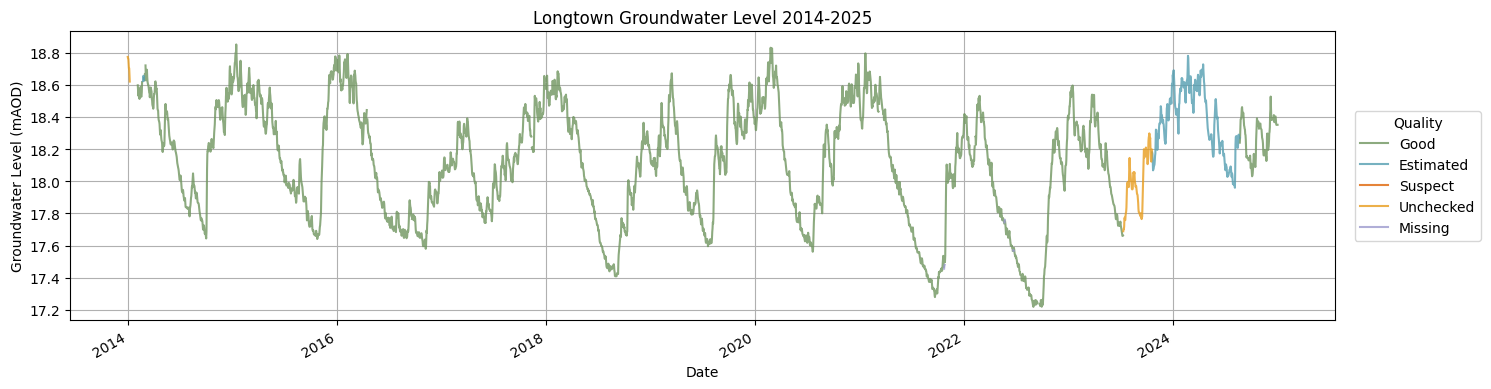

Columns for Scaleby:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 3985



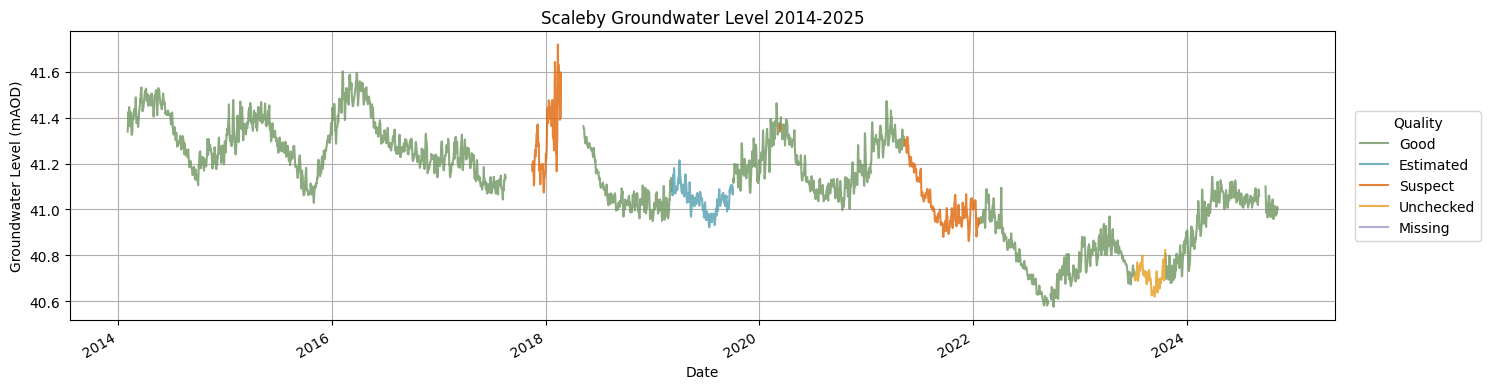

Columns for Castle_Carrock:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



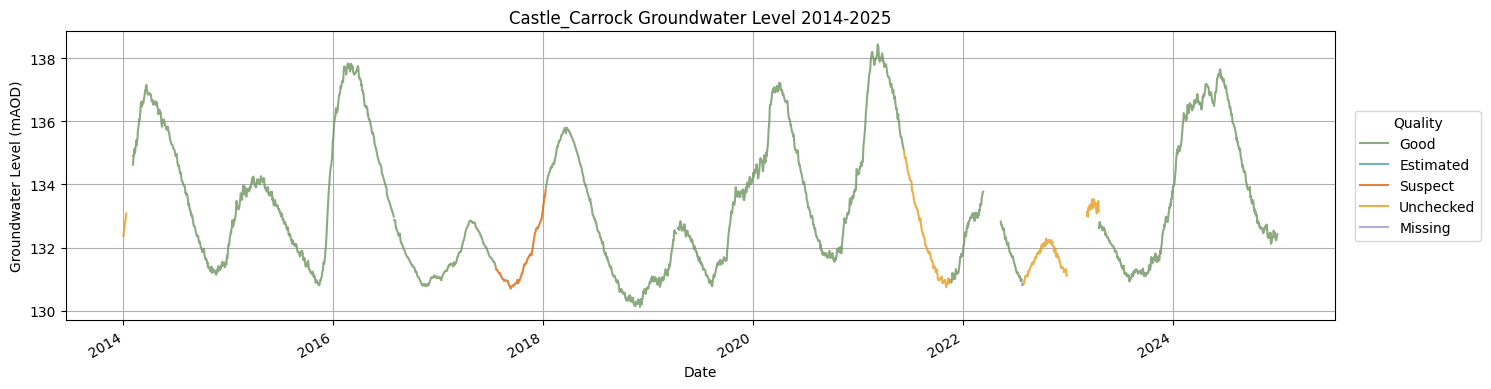

Columns for Croglin:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 3964



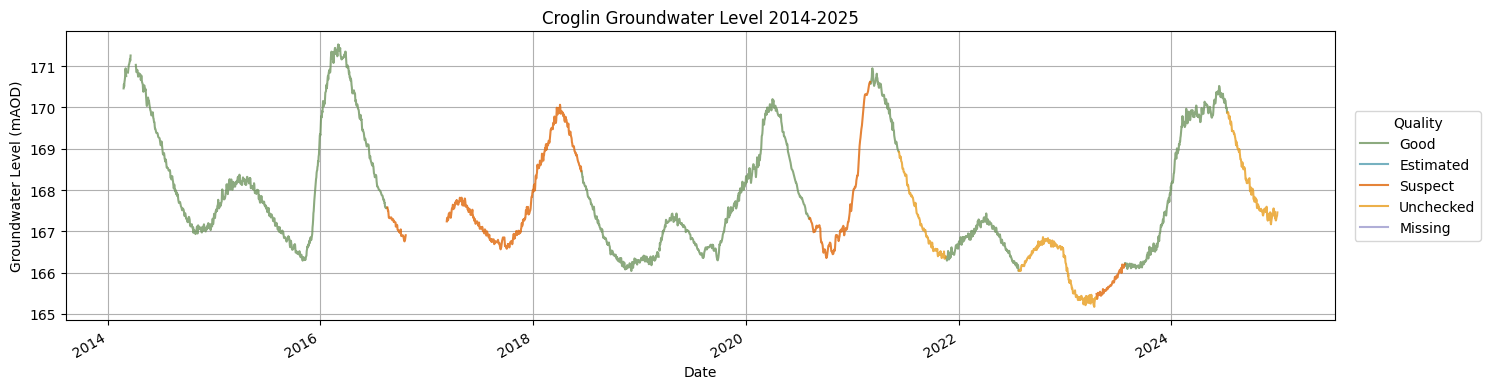

Columns for Baronwood:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



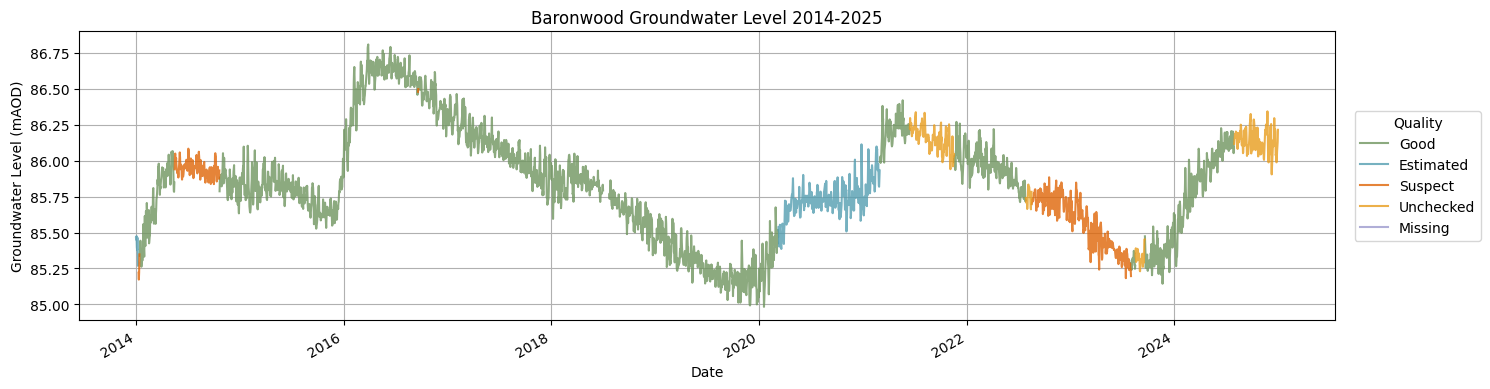

Columns for Renwick:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



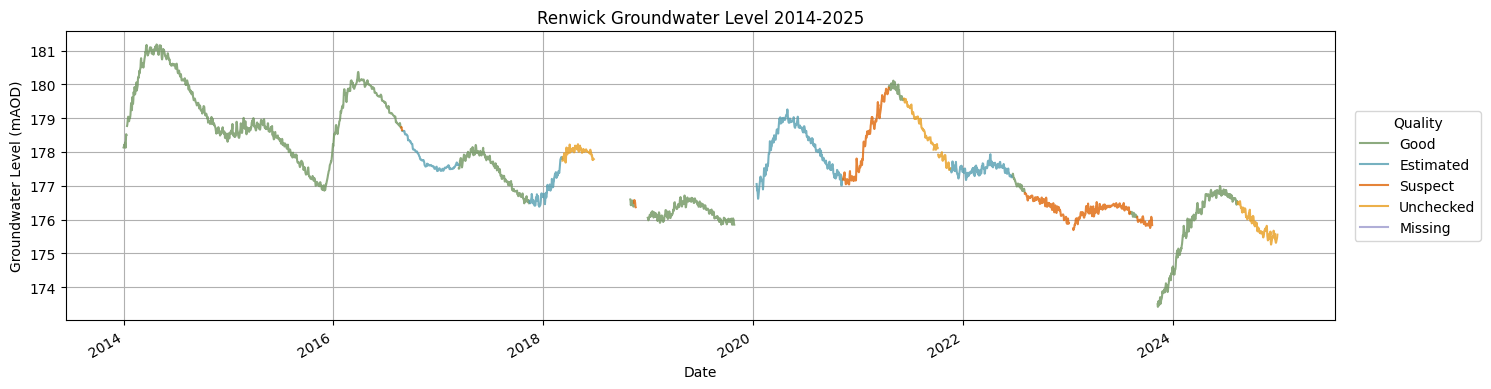

Columns for East_Brownrigg:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



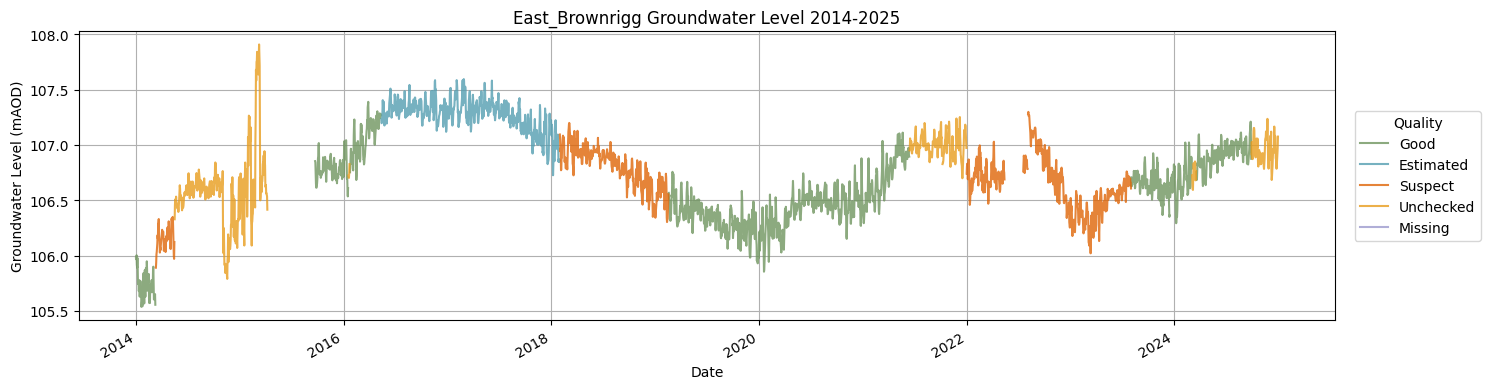

Columns for Bgs_Ev2:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



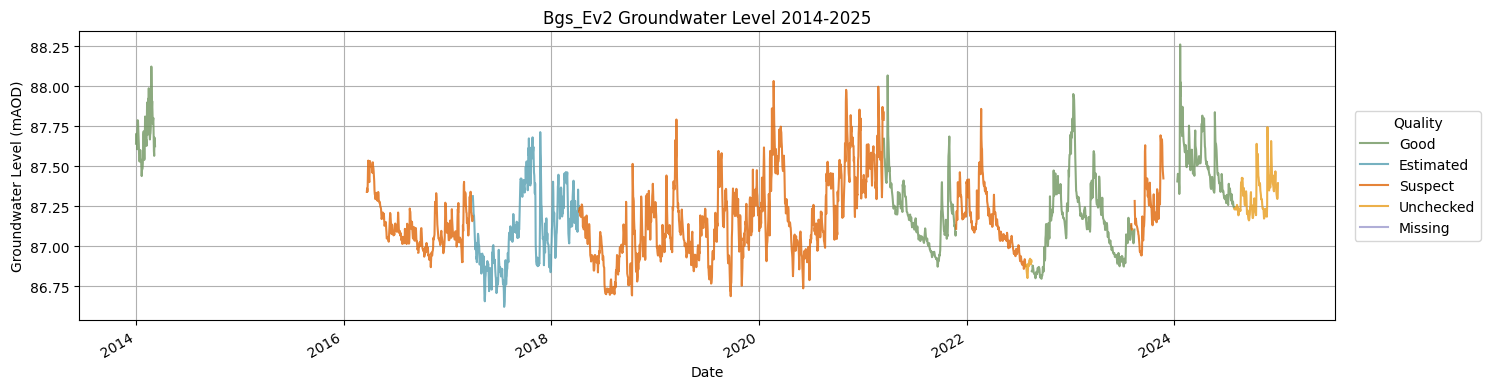

Columns for Penrith_North:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 3927



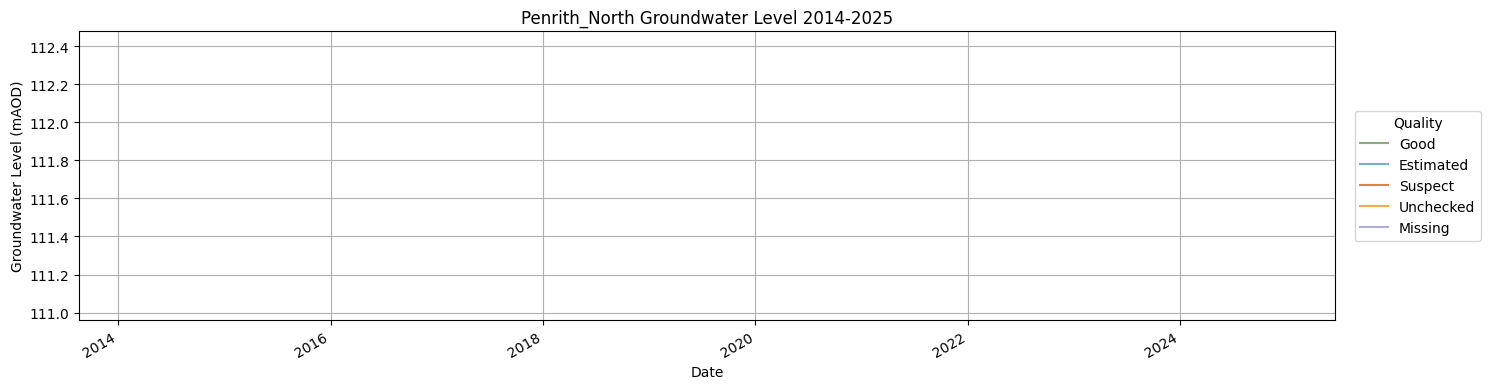

Columns for Skirwith:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



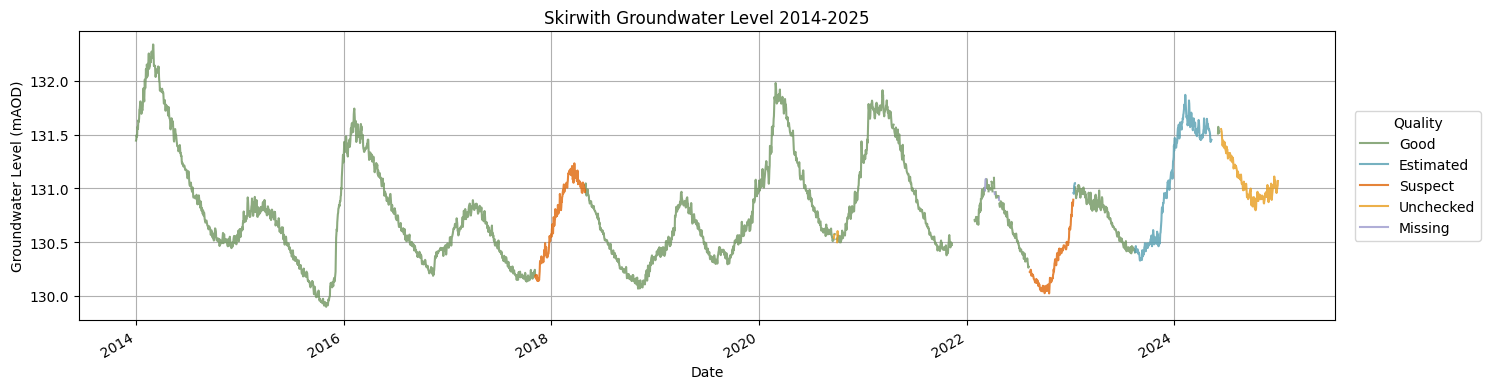

Columns for Cliburn_Town_Bridge_1:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



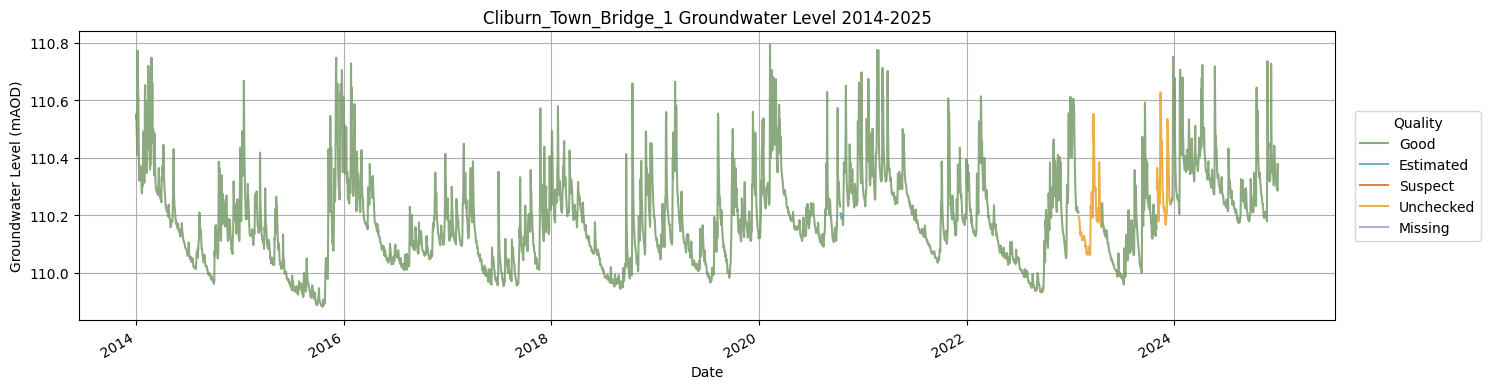

Columns for Hilton:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



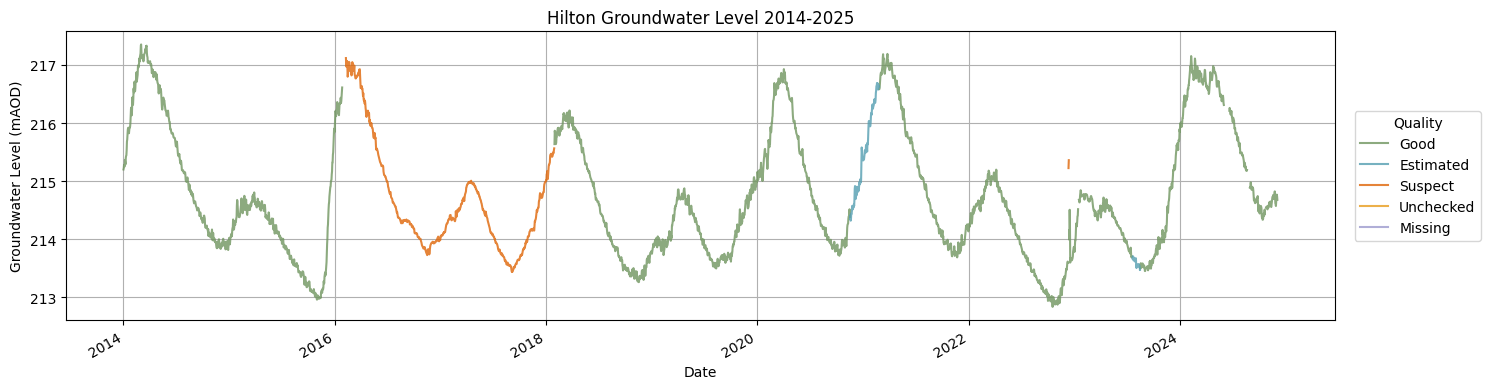

Columns for Coupland:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



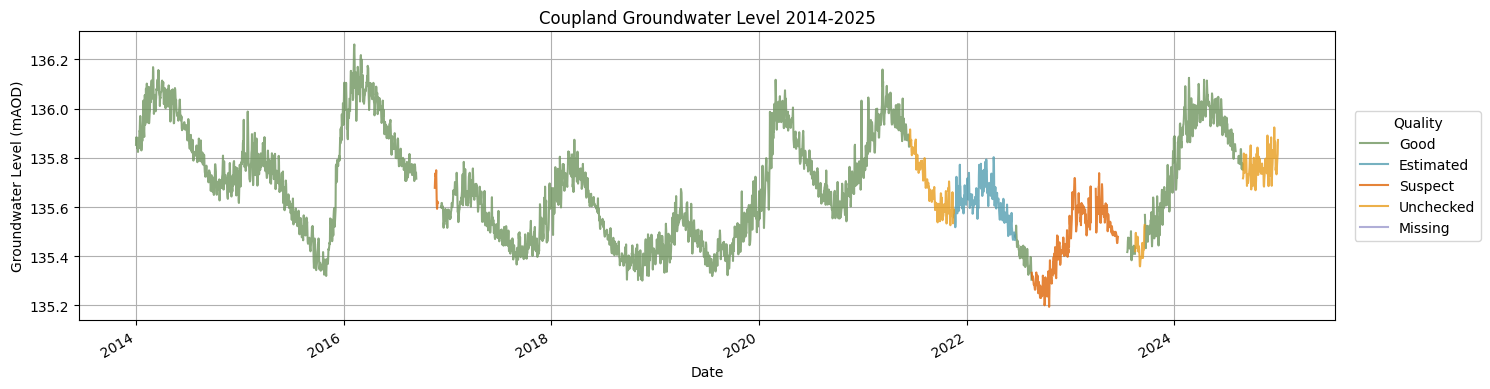

Columns for Great_Musgrave:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



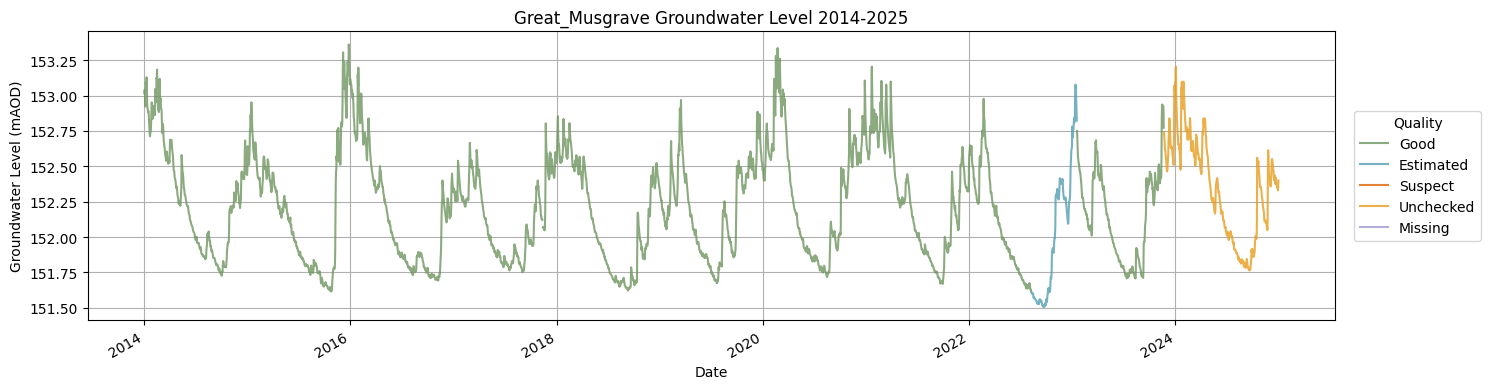

Columns for East_Curthwaite:
    Index(['dateTime', 'station_name', 'date', 'value', 'quality', 'measure'], dtype='object')
    Total Entries: 4018



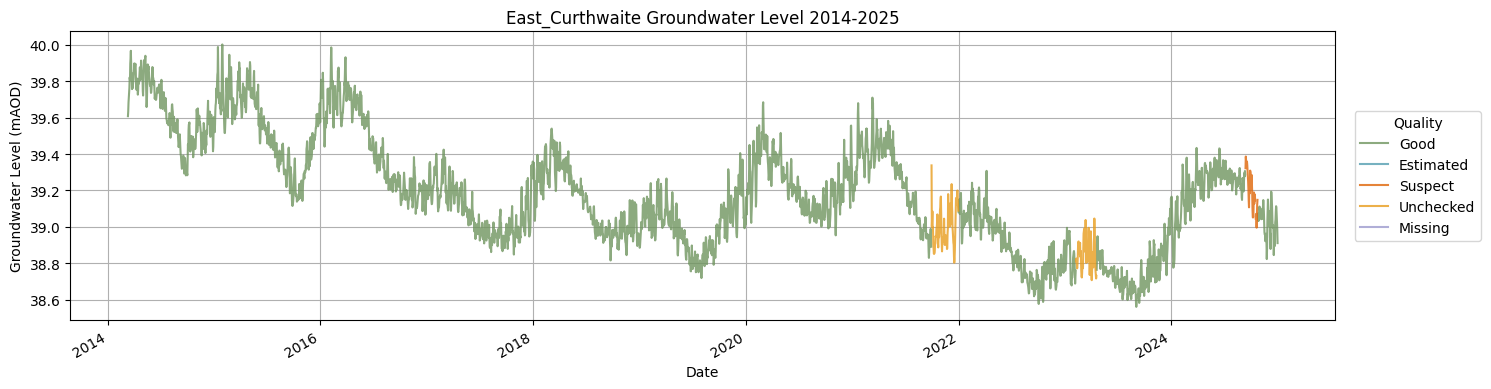

In [33]:
def plot_timeseries(time_series_raw, station_name):
    """Resusable matplotlib time series plot"""
    fig, ax = plt.subplots(figsize=(15, 4))
    time_series_raw['dateTime'] = pd.to_datetime(time_series_raw['dateTime'], errors='coerce')

    # Define fixed colours for each quality level
    quality_colors = {
        'Good': '#70955F',
        'Estimated': '#549EB1',
        'Suspect': '#DF6607',
        'Unchecked': '#e89c1d',
        'Missing': '#9c9acd'
    }
    
    # Plot using qualities score as legend
    for quality, color in quality_colors.items():
        temp = time_series_raw.copy()
        temp['value'] = temp['value'].where(temp['quality'] == quality, pd.NA)
        ax.plot(temp['dateTime'], temp['value'], label=quality, color=color, alpha=0.8)

    # Apply auto locators and formatters to clean up ticks
    locator = mdates.AutoDateLocator(minticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()
    
    ax.set_title(f'{station_name} Groundwater Level 2014-2025')
    ax.set_xlabel('Date')
    ax.set_ylabel('Groundwater Level (mAOD)')
    ax.grid()
    ax.legend(title="Quality", loc="center left", bbox_to_anchor=(1.01, 0.5))
    
    plt.tight_layout()
    plt.savefig(f"figures/eden_catchment/raw_timeseries_plots/{station_name}_raw_plot_.png", dpi=300)
    plt.show()

# Plot data at a daily resolution
for station in daily_time_series:
    print(f'Columns for {station}:\n    {daily_time_series[station].columns}\n    Total Entries: {len(daily_time_series[station])}\n')
    plot_timeseries(daily_time_series[station], station)

Create geodataframes for stations:

In [ ]:
# from shapely.geometry import Point

# # Convert to GeoDataFrame using WGS84 (lat/lon)
# stations_gdf = gpd.GeoDataFrame(
#     stations_df,
#     geometry=gpd.points_from_xy(stations_df['lon'], stations_df['lat']),
#     crs="EPSG:4326"
# )

# # Reproject to match mesh CRS (British National Grid)
# stations_gdf = stations_gdf.to_crs("EPSG:27700")


Snap stations to nearest mesh node

In [ ]:
# from shapely.ops import nearest_points
# import shapely.geometry

# # Rebuild mesh index
# mesh_sindex = mesh_nodes_gdf.sindex

# def find_nearest_node(station_point):
#     # This is the key fix: pass geometry directly, not as a list
#     nearest_idx = list(mesh_sindex.nearest(station_point, return_all=False))[0]

#     nearest_row = mesh_nodes_gdf.iloc[nearest_idx]
#     nearest_geom = nearest_row.geometry

#     # Ensure it's a proper Shapely Point
#     if hasattr(nearest_geom, '__geo_interface__') and not isinstance(nearest_geom, shapely.geometry.base.BaseGeometry):
#         nearest_geom = shapely.geometry.shape(nearest_geom)

#     return pd.Series({
#         'nearest_node_id': int(nearest_row['node_id']),
#         'nearest_geometry': nearest_geom
#     })


# # Apply snapping
# stations_gdf[['nearest_node_id', 'nearest_geometry']] = stations_gdf.geometry.apply(find_nearest_node)
# stations_gdf = stations_gdf.set_geometry('nearest_geometry').to_crs("EPSG:4326")
# stations_gdf['lat'] = stations_gdf.geometry.y
# stations_gdf['lon'] = stations_gdf.geometry.x


In [ ]:
print(stations_gdf[['station_id', 'nearest_node_id', 'lat', 'lon']])

In [ ]:
import folium

# Recreate map centered on catchment
map_center = [mesh_nodes_gdf['lat'].mean(), mesh_nodes_gdf['lon'].mean()]
map = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron")

# Add snapped station locations
for _, row in stations_gdf.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['station_id']} → Node {row['nearest_node_id']}"
    ).add_to(map)

# Optionally add mesh nodes
for _, row in mesh_nodes_gdf.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=1,
        color="#354c7c",
        fill=True,
        fill_opacity=0.6
    ).add_to(map)

# Save
map.save("figures/station_to_mesh_snapping.html")
map


In [ ]:
print(stations_gdf[['station_id', 'nearest_node_id', 'geometry']])
print(stations_gdf.crs)
